In [ ]:
pip install datamapplot

# Bibliotecas

In [1]:
import sys
import os

# Adiciona o diretório raiz do projeto ao sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from config import settings
from src.analyzes.AutoClusterHPO import AutoClusterHPO
import google.generativeai as genai
from typing import Mapping, List, Tuple
from dotenv import load_dotenv
import time
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.representation import BaseRepresentation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import pandas as pd
import random
from transformers import pipeline
import emoji
import spacy
from scipy.sparse import csr_matrix
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import datamapplot
from bertopic import plotting
from hdbscan import HDBSCAN
from nltk.corpus import stopwords
nltk.download('stopwords') # Baixar se for a primeira vez
stop_words_pt = stopwords.words('portuguese')

load_dotenv()

pd.set_option('display.float_format', '{:.2f}'.format)
API_KEY = os.getenv("API_GEMINI")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Leitura de Dados

In [2]:
df_comments = pd.read_excel(settings.ALL_XLSX, sheet_name="reels_latestComments")

cols = ['text clean', 'sentiment_label', 'sentiment_score',
       'text_demojized', 'Topic', 'Name', 'Representation',
       'Representative_Docs', 'Top_n_words', 'Probability',
       'Representative_document']

df_comments = df_comments.drop(cols, axis=1, errors='ignore')

df_comments.columns

Index(['inputUrl', 'id_reel', 'type', 'shortCode', 'caption', 'url',
       'commentsCount', 'firstComment', 'dimensionsHeight', 'dimensionsWidth',
       'displayUrl', 'videoUrl', 'alt', 'likesCount_reel', 'videoViewCount',
       'videoPlayCount', 'timestamp_reel', 'ownerFullName',
       'ownerUsername_reel', 'ownerId', 'productType', 'videoDuration',
       'isSponsored', 'isCommentsDisabled', 'locationName', 'locationId',
       'isPinned', 'data_hora', 'Width X Height', 'Total de Engajamento',
       'Tipo', 'id_comment', 'text', 'ownerUsername_comment',
       'ownerProfilePicUrl', 'timestamp_comment', 'repliesCount',
       'likesCount_comment', 'owner.id', 'owner.is_verified',
       'owner.profile_pic_url', 'owner.username', 'comprimento texto'],
      dtype='object')

In [3]:
df_reels = pd.read_excel(settings.ALL_XLSX, sheet_name="reels")

cols = ['PC1_Engajamento_videoPlay', 'PC2_videoDuration',
       'Clusters (AutoClusterHPO)', 'model', 'config', 'score', 'algo_name']

df_reels = df_reels.drop(cols, axis=1, errors='ignore')

df_reels.columns

Index(['inputUrl', 'id', 'type', 'shortCode', 'caption', 'hashtags',
       'mentions', 'url', 'commentsCount', 'firstComment', 'latestComments',
       'dimensionsHeight', 'dimensionsWidth', 'displayUrl', 'images',
       'videoUrl', 'alt', 'likesCount', 'videoViewCount', 'videoPlayCount',
       'timestamp', 'childPosts', 'ownerFullName', 'ownerUsername', 'ownerId',
       'productType', 'videoDuration', 'isSponsored', 'musicInfo',
       'isCommentsDisabled', 'taggedUsers', 'coauthorProducers',
       'locationName', 'locationId', 'isPinned', 'data_hora', 'Width X Height',
       'Total de Engajamento', 'Tipo'],
      dtype='object')

# Análise de Componentes Principais

In [4]:
# @title
df = df_reels[['commentsCount', 'likesCount', 'videoPlayCount', 'videoDuration']].copy()

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Instancia PCA
pca = PCA(n_components=2)
pca.fit(df_scaled)

# Transformar os dados
dados_pca = pca.transform(df_scaled)

# Colocar em DataFrame
df_pca = pd.DataFrame(
    dados_pca,
    columns=[f"PC{i+1}" for i in range(2)]
)

df_pca.head()

,PC1,PC2
0,-0.40,-0.12
1,0.35,0.14
2,-0.46,-0.10
3,-0.73,-0.43
4,-0.54,-0.12


In [5]:
# @title
# Porcentagem de variância explicada por cada componente
expl_var = pca.explained_variance_ratio_
dados = {'Componente': [f'PC{i+1}' for i in range(len(expl_var))], 'Variância Explicada': expl_var, 'Variancia Acumulada': np.cumsum(expl_var)}
df_expl_var = pd.DataFrame(dados)
df_expl_var

,Componente,Variância Explicada,Variancia Acumulada
0,PC1,0.67,0.67
1,PC2,0.25,0.92


In [6]:
# @title
loadings = pd.DataFrame(
    pca.components_.T,
    index=df.columns,
    columns=[f"PC{i+1}" for i in range(2)]
)

loadings

,PC1,PC2
commentsCount,0.56,0.06
likesCount,0.59,0.02
videoPlayCount,0.57,-0.02
videoDuration,-0.04,1.00


In [7]:
# Adiciona a primeira coluna de dados_pca como a nova coluna 'PC1'
df_reels['PC1_Engajamento_videoPlay'] = dados_pca[:, 0]

# Adiciona a segunda coluna de dados_pca como a nova coluna 'PC2'
df_reels['PC2_videoDuration'] = dados_pca[:, 1]

# Clusterização

In [8]:
autocluster_tool = AutoClusterHPO(max_evals_per_algo=100) 
clusters, models, configs, scores, algo_names= autocluster_tool.fit_predict(df_reels[['PC1_Engajamento_videoPlay', 'PC2_videoDuration']])

df_reels['Clusters (AutoClusterHPO)'] = clusters
df_reels['model'] = models
df_reels['config'] = configs
df_reels['score'] = scores
df_reels['algo_name'] = algo_names

Iniciando otimização de hiperparâmetros...
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [00:02<00:00, 37.19trial/s, best loss: -0.6555726678520698]

Processo de AutoCluster concluído.
Melhor algoritmo: DBSCAN
Melhores parâmetros: {'eps': 1.403665768897381, 'min_samples': 5}
Melhor pontuação CVI combinada: 0.6594


In [10]:
df_reels.columns

Index(['inputUrl', 'id', 'type', 'shortCode', 'caption', 'hashtags',
       'mentions', 'url', 'commentsCount', 'firstComment', 'latestComments',
       'dimensionsHeight', 'dimensionsWidth', 'displayUrl', 'images',
       'videoUrl', 'alt', 'likesCount', 'videoViewCount', 'videoPlayCount',
       'timestamp', 'childPosts', 'ownerFullName', 'ownerUsername', 'ownerId',
       'productType', 'videoDuration', 'isSponsored', 'musicInfo',
       'isCommentsDisabled', 'taggedUsers', 'coauthorProducers',
       'locationName', 'locationId', 'isPinned', 'data_hora', 'Width X Height',
       'Total de Engajamento', 'Tipo', 'PC1_Engajamento_videoPlay',
       'PC2_videoDuration', 'Clusters (AutoClusterHPO)', 'model', 'config',
       'score', 'algo_name'],
      dtype='object')

# Análise de Sentimentos

In [11]:
# 1. Inicializa o pipeline (seu código original está perfeito)
# O modelo 'cardiffnlp/twitter-xlm-roberta-base-sentiment' retorna os rótulos: 'Positive', 'Negative', 'Neutral'
analisador_sentimento = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-xlm-roberta-base-sentiment"
)

# 2. Modifica a função para retornar tanto o LABEL quanto o SCORE
def analisar_sentimento_completo(texto):
    """
    Esta função recebe um texto, analisa o sentimento e retorna um
    pd.Series com o rótulo e a pontuação, pronto para ser adicionado
    a um DataFrame.
    """
    if pd.notna(texto) and texto.strip() != "":
        try:
            # O resultado é uma lista com um dicionário, ex: [{'label': 'Positive', 'score': 0.99}]
            resultado = analisador_sentimento(texto, truncation=True, max_length=512)[0]
            label = resultado['label']
            score = resultado['score']
            return pd.Series([label, score])
        except Exception as e:
            # Retorna None em caso de erro na análise
            return pd.Series([None, None])
    else: 
        # Retorna None se o texto for nulo ou vazio
        return pd.Series([None, None])

# 3. Aplica a nova função e cria DUAS novas colunas de uma vez
# O 'apply' vai expandir o pd.Series retornado para as colunas especificadas
df_comments[['sentiment_label', 'sentiment_score']] = df_comments['text'].apply(analisar_sentimento_completo)

print("\nDistribuição dos sentimentos:")
df_comments['sentiment_label'].value_counts()

Device set to use cpu



Distribuição dos sentimentos:


sentiment_label
positive    4788
neutral      955
negative     918
Name: count, dtype: int64

In [12]:
df_comments.columns

Index(['inputUrl', 'id_reel', 'type', 'shortCode', 'caption', 'url',
       'commentsCount', 'firstComment', 'dimensionsHeight', 'dimensionsWidth',
       'displayUrl', 'videoUrl', 'alt', 'likesCount_reel', 'videoViewCount',
       'videoPlayCount', 'timestamp_reel', 'ownerFullName',
       'ownerUsername_reel', 'ownerId', 'productType', 'videoDuration',
       'isSponsored', 'isCommentsDisabled', 'locationName', 'locationId',
       'isPinned', 'data_hora', 'Width X Height', 'Total de Engajamento',
       'Tipo', 'id_comment', 'text', 'ownerUsername_comment',
       'ownerProfilePicUrl', 'timestamp_comment', 'repliesCount',
       'likesCount_comment', 'owner.id', 'owner.is_verified',
       'owner.profile_pic_url', 'owner.username', 'comprimento texto',
       'sentiment_label', 'sentiment_score'],
      dtype='object')

# Pré-processamento

In [13]:
# Função para remover stop words de um texto
def remover_stopwords(texto):
    if not isinstance(texto, str):  # Se não for string, retorna vazio
        return ""
    palavras = texto.split()
    palavras_filtradas = [p for p in palavras if p.lower() not in stop_words_pt]
    return " ".join(palavras_filtradas)

# Aplicar a todos os comentários negativos
df_comments['text clean'] = df_comments['text'].apply(remover_stopwords)

# Supondo que df_comments é seu DataFrame
# A função demojize transforma '😂' em ':face_with_tears_of_joy:'
# Usar language='pt' pode ajudar a obter descrições em português, se disponíveis.
def demojize_text(text):
    return emoji.demojize(text, language='pt')

df_comments['text_demojized'] = df_comments['text clean'].apply(demojize_text)

In [14]:
df_comments.columns

Index(['inputUrl', 'id_reel', 'type', 'shortCode', 'caption', 'url',
       'commentsCount', 'firstComment', 'dimensionsHeight', 'dimensionsWidth',
       'displayUrl', 'videoUrl', 'alt', 'likesCount_reel', 'videoViewCount',
       'videoPlayCount', 'timestamp_reel', 'ownerFullName',
       'ownerUsername_reel', 'ownerId', 'productType', 'videoDuration',
       'isSponsored', 'isCommentsDisabled', 'locationName', 'locationId',
       'isPinned', 'data_hora', 'Width X Height', 'Total de Engajamento',
       'Tipo', 'id_comment', 'text', 'ownerUsername_comment',
       'ownerProfilePicUrl', 'timestamp_comment', 'repliesCount',
       'likesCount_comment', 'owner.id', 'owner.is_verified',
       'owner.profile_pic_url', 'owner.username', 'comprimento texto',
       'sentiment_label', 'sentiment_score', 'text clean', 'text_demojized'],
      dtype='object')

# Modelagem de Tópicos

In [15]:
class GeminiDocsRefiner(BaseRepresentation):
    def __init__(self, api_key: str, model: str = "gemini-2.0-flash", prompt_template: str = None):
        genai.configure(api_key=api_key)
        self.model = model
        # Prompt aprimorado para receber exemplos de documentos
        self.prompt_template = prompt_template or (
            "Escreva uma descrição de um parágrafo que descreva detalhadamente o que os comentários do instagram presentes neste tópico tem em comum: {documents}"
        )

    def extract_topics(
        self,
        topic_model,
        documents: pd.DataFrame, # Recebe o DataFrame de documentos
        c_tf_idf: csr_matrix,
        topics: Mapping[str, List[Tuple[str, float]]]
    ) -> Mapping[str, List[Tuple[str, float]]]:
        
        updated_topics = {}
        # Mapeia cada documento ao seu tópico para fácil acesso
        docs_per_topic = documents.groupby(['Topic'])['Document'].apply(list)

        for topic_id, keywords in topics.items():
            
            if topic_id == -1:
                updated_topics[topic_id] = keywords
                continue

            if topic_id % 10 == 0:
                time.sleep(60)
            
            try:
                # Pega os documentos reais do tópico
                topic_docs = docs_per_topic.get(topic_id, [])
                if not topic_docs:
                    updated_topics[topic_id] = keywords
                    continue

                # Pega uma amostra para não exceder o limite do prompt
                sample_size = min(len(topic_docs), 10) # Amostra de até 10 documentos
                docs_sample = "\n- ".join(random.sample(topic_docs, sample_size))
                
                prompt = self.prompt_template.format(documents=docs_sample)

                response = genai.GenerativeModel(self.model).generate_content(prompt)
                label = response.text.strip() if hasattr(response, "text") else None

                if label:
                    # Adiciona o novo rótulo com a maior pontuação
                    updated_keywords = [(label, 1.0)] + keywords 
                    updated_topics[topic_id] = updated_keywords
                else:
                    updated_topics[topic_id] = keywords  # Fallback

            except Exception as e:
                print(f"[GeminiDocsRefiner] Erro no tópico {topic_id}: {e}")
                updated_topics[topic_id] = keywords  # Fallback

        return updated_topics

In [16]:
list_dataframes = []

representation_model = GeminiDocsRefiner(api_key=API_KEY)

# Regex: captura palavras com 2+ caracteres OU qualquer caractere no bloco de Emojis Unicode
# Isso mantém as palavras normais e adiciona os emojis como tokens
emoji_pattern = r"(?u)\b\w\w+\b|[\U0001F300-\U0001F5FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\u2600-\u26FF\u2700-\u27BF]"

vectorizer_model = CountVectorizer(token_pattern=emoji_pattern)

hdbscan_model = HDBSCAN(min_cluster_size=15, 
                        min_samples=5,
                        metric='euclidean', 
                        cluster_selection_method='eom', 
                        prediction_data=True)

topic_model = BERTopic(
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    representation_model=representation_model,
    embedding_model="rufimelo/bert-large-portuguese-cased-sts",
    language="multilingual",
    calculate_probabilities=True,
    verbose=True
)

# Agora, use esta nova coluna para a modelagem
docs_completos = list(df_comments['text_demojized'])

print(f"Iniciando a modelagem de tópicos em {len(docs_completos)} documentos...")
topics, probs = topic_model.fit_transform(docs_completos)
print("Modelagem global de tópicos concluída.")

print("Iniciando a redução de tópicos...")
topic_model.reduce_topics(docs_completos, nr_topics=50)
print("Redução de tópicos concluída.")

# Obtém as informações de tópico para TODOS os documentos
topic_info_df = topic_model.get_document_info(docs_completos)

# Reseta o índice de ambos para garantir o alinhamento
df_comments_reset = df_comments.reset_index(drop=True)
topic_info_df_reset = topic_info_df.reset_index(drop=True)

# Concatena os DataFrames originais com os resultados da modelagem
df_comments_final = pd.concat([df_comments_reset, topic_info_df_reset], axis=1)

# (Opcional) Remove a coluna de documento duplicada
df_comments_final = df_comments_final.drop(columns=['Document'])

print("DataFrame final com resultados globais:")
df_comments_final.head()


2025-10-18 20:28:24,330 - BERTopic - Embedding - Transforming documents to embeddings.


Iniciando a modelagem de tópicos em 6686 documentos...


Invalid model-index. Not loading eval results into CardData.
Batches: 100%|██████████| 209/209 [14:06<00:00,  4.05s/it]
2025-10-18 20:42:34,500 - BERTopic - Embedding - Completed ✓
2025-10-18 20:42:34,508 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-18 20:43:01,519 - BERTopic - Dimensionality - Completed ✓
2025-10-18 20:43:01,519 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-18 20:43:05,290 - BERTopic - Cluster - Completed ✓
2025-10-18 20:43:05,305 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-18 20:58:24,565 - BERTopic - Representation - Completed ✓
2025-10-18 20:58:24,798 - BERTopic - Topic reduction - Reducing number of topics
2025-10-18 20:58:24,831 - BERTopic - Representation - Fine-tuning topics using representation models.


Modelagem global de tópicos concluída.
Iniciando a redução de tópicos...


2025-10-18 21:04:50,512 - BERTopic - Representation - Completed ✓
2025-10-18 21:04:50,529 - BERTopic - Topic reduction - Reduced number of topics from 117 to 50


Redução de tópicos concluída.
DataFrame final com resultados globais:


,inputUrl,id_reel,type,shortCode,caption,url,commentsCount,firstComment,dimensionsHeight,dimensionsWidth,...,sentiment_score,text clean,text_demojized,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,https://www.instagram.com/ibaneisoficial,3652885411493374185,Video,DKxp-2NROjp,Participei do 2º Brasília Summit Lide para dis...,https://www.instagram.com/p/DKxp-2NROjp/,476,E a educação e saúde?,1136,640,...,0.82,educação saúde?,educação saúde?,13,13_Os comentários no Instagram demonstram uma ...,[Os comentários no Instagram demonstram uma pr...,[Queremos melhore atendimento saúde nessas upa...,Os comentários no Instagram demonstram uma pre...,0.11,False
1,https://www.instagram.com/ibaneisoficial,3652885411493374185,Video,DKxp-2NROjp,Participei do 2º Brasília Summit Lide para dis...,https://www.instagram.com/p/DKxp-2NROjp/,476,E a educação e saúde?,1136,640,...,0.77,Leva turista rodoviária plano piloto dia opera...,Leva turista rodoviária plano piloto dia opera...,-1,-1_governador_pra_parabéns_vc,"[governador, pra, parabéns, vc, trabalho, gove...","[governador, governador :mãos_aplaudindo::mãos...",governador - pra - parabéns - vc - trabalho - ...,0.71,False
2,https://www.instagram.com/ibaneisoficial,3652885411493374185,Video,DKxp-2NROjp,Participei do 2º Brasília Summit Lide para dis...,https://www.instagram.com/p/DKxp-2NROjp/,476,E a educação e saúde?,1136,640,...,0.91,Saúde educação 👎👎👎,Saúde educação :polegar_para_baixo::polegar_pa...,7,7_Os comentários do Instagram nesse tópico com...,[Os comentários do Instagram nesse tópico comp...,[:mãos_para_cima::mãos_para_cima::mãos_para_ci...,Os comentários do Instagram nesse tópico compa...,0.07,False
3,https://www.instagram.com/ibaneisoficial,3652885411493374185,Video,DKxp-2NROjp,Participei do 2º Brasília Summit Lide para dis...,https://www.instagram.com/p/DKxp-2NROjp/,476,E a educação e saúde?,1136,640,...,0.84,"Ibanes, preciso filho volte escola, acabe logo...","Ibanes, preciso filho volte escola, acabe logo...",2,2_Os comentários no Instagram agrupam-se em to...,[Os comentários no Instagram agrupam-se em tor...,"[Governador, nomeie professores aprovados últi...",Os comentários no Instagram agrupam-se em torn...,0.14,False
4,https://www.instagram.com/ibaneisoficial,3652885411493374185,Video,DKxp-2NROjp,Participei do 2º Brasília Summit Lide para dis...,https://www.instagram.com/p/DKxp-2NROjp/,476,E a educação e saúde?,1136,640,...,0.46,aí Governador @ibaneisoficial 👏👏👏 #maisnomeaco...,aí Governador @ibaneisoficial :mãos_aplaudindo...,-1,-1_governador_pra_parabéns_vc,"[governador, pra, parabéns, vc, trabalho, gove...","[governador, governador :mãos_aplaudindo::mãos...",governador - pra - parabéns - vc - trabalho - ...,0.57,False


In [17]:
df_comments_final.columns

Index(['inputUrl', 'id_reel', 'type', 'shortCode', 'caption', 'url',
       'commentsCount', 'firstComment', 'dimensionsHeight', 'dimensionsWidth',
       'displayUrl', 'videoUrl', 'alt', 'likesCount_reel', 'videoViewCount',
       'videoPlayCount', 'timestamp_reel', 'ownerFullName',
       'ownerUsername_reel', 'ownerId', 'productType', 'videoDuration',
       'isSponsored', 'isCommentsDisabled', 'locationName', 'locationId',
       'isPinned', 'data_hora', 'Width X Height', 'Total de Engajamento',
       'Tipo', 'id_comment', 'text', 'ownerUsername_comment',
       'ownerProfilePicUrl', 'timestamp_comment', 'repliesCount',
       'likesCount_comment', 'owner.id', 'owner.is_verified',
       'owner.profile_pic_url', 'owner.username', 'comprimento texto',
       'sentiment_label', 'sentiment_score', 'text clean', 'text_demojized',
       'Topic', 'Name', 'Representation', 'Representative_Docs', 'Top_n_words',
       'Probability', 'Representative_document'],
      dtype='object')

# Salvar dados Modelados

In [18]:
try:
    # 2. Use o pd.ExcelWriter em um bloco 'with' para garantir que o arquivo seja salvo e fechado corretamente
    with pd.ExcelWriter(
        settings.ALL_XLSX,
        mode="a",  # 'a' significa "append" (adicionar/anexar)
        engine="openpyxl",
        if_sheet_exists="replace"  # Substitui a aba se ela já existir
    ) as writer:
        
        # 3. Salve seu DataFrame na aba especificada
        df_comments_final.to_excel(writer, sheet_name='reels_latestComments', index=False)
        df_reels.to_excel(writer, sheet_name='reels', index=False)

except FileNotFoundError:
    print(f"Aviso: O arquivo '{settings.ALL_XLSX}' não foi encontrado.")
    print("Um novo arquivo será criado com a aba especificada.")
    # Se o arquivo não existir, o modo 'a' falha. Então, simplesmente o criamos.
    df_final.to_excel('reels_latestComments.xlsx', sheet_name='reels_latestComments', index=False)

except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

# Vizualizações

## Análise de Componentes Principais

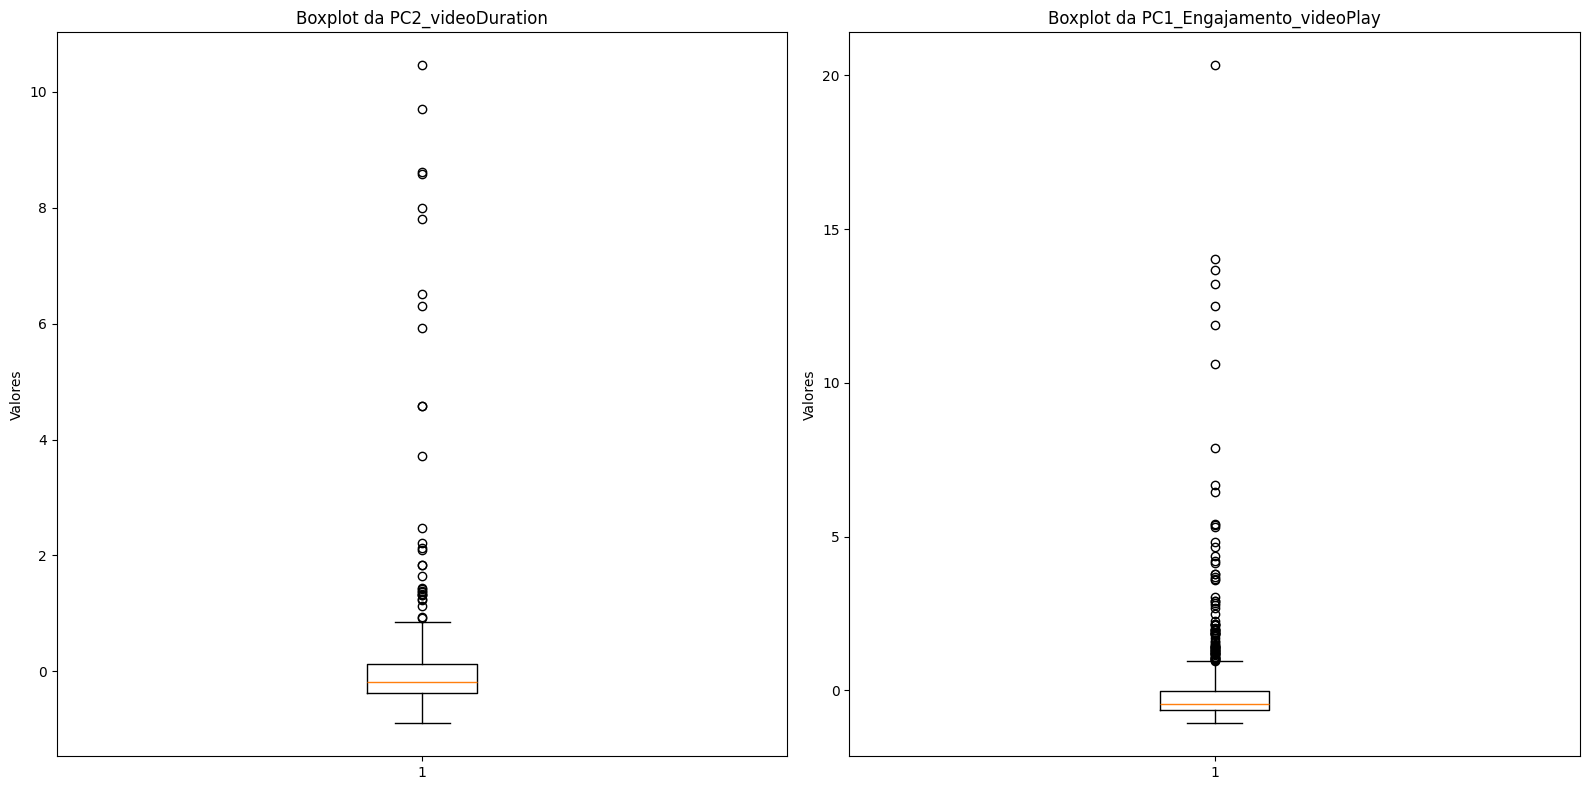

In [19]:
def plotarFigura1():

    df = df_reels[['PC2_videoDuration', 'PC1_Engajamento_videoPlay']]

    # 2. Criar a figura e os eixos (subplots)
    # A estrutura da grade continua a mesma: 2 linhas e 4 colunas.
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

    # 3. "Achatando" o array de eixos para facilitar a iteração
    axes = axes.flatten()

    # 4. Iterar pelas colunas do DataFrame e plotar cada uma em um eixo
    # Usamos enumerate(df.columns) para obter tanto o índice (i) quanto o nome da coluna.
    for i, col_name in enumerate(df.columns):
        # Selecionamos o eixo atual (axes[i])
        ax = axes[i]
        
        # Criamos o boxplot usando os dados da coluna atual (df[col_name])
        ax.boxplot(df[col_name])
        
        # Usamos o nome da coluna como título do subplot
        ax.set_title(f'Boxplot da {col_name}')
        ax.set_ylabel('Valores')

    # 5. Ajustar o layout para evitar sobreposição
    plt.tight_layout()

    # 6. Salvar e exibir o gráfico
    plt.savefig('boxplot_do_dataframe.png')

    # Mostra a figura gerada
    plt.show()

plotarFigura1()

## Clusterização

In [20]:
def analiseValidacaoModeloPCA(df_cluster, algo_name, score):    

    # Criação da figura e layout
    fig = plt.figure(figsize=(10, 5))  # Wider figure to accommodate elements
    gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[3, 1], wspace=0.1)
    subgs = gs[0, 1].subgridspec(3, 1)
    fig.suptitle(f"Análise de Validação do Modelo", fontsize=18, color='black', fontweight='bold', y=0.98)
                
    # Visualização dos clusters com PCA
    axes_gs_principal = fig.add_subplot(gs[0, 0])
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=df_cluster, x=df_cluster.columns[0], y=df_cluster.columns[1], hue='Clusters (AutoClusterHPO)', palette='deep', s=100, ax=axes_gs_principal) 
    axes_gs_principal.set_xlabel(df_cluster.columns[0])
    axes_gs_principal.set_ylabel(df_cluster.columns[1])
    axes_gs_principal.grid(True)

    if algo_name == 'AgglomerativeClustering':
        algo_name = '\n'.join([algo_name[:13], algo_name[13:]])
    
    # Card com o Índice de Silhueta
    ax2 = fig.add_subplot(subgs[0, 0])
    ax2.axis('off')
    rect2 = plt.Rectangle((0, 0), 1, 1,  linewidth=1.5, edgecolor='black', facecolor='white', transform=ax2.transAxes)
    ax2.add_patch(rect2)
    ax2.text(0.5, 0.7, f"{algo_name}", ha='center', va='center', fontsize=14,fontweight='bold')
    ax2.text(0.5, 0.4, "Modelo",  ha='center', va='center', fontsize=9)

    # Card com o índice Davies-Bouldin
    ax3 = fig.add_subplot(subgs[1, 0])
    ax3.axis('off')
    rect3 = plt.Rectangle((0, 0), 1, 1,  linewidth=1.5, edgecolor='black', facecolor='white', transform=ax3.transAxes)
    ax3.add_patch(rect3)
    ax3.text(0.5, 0.7, f"{score:.4f}", ha='center', va='center', fontsize=14,fontweight='bold')
    ax3.text(0.5, 0.32, "CVI combinada",  ha='center', va='center', fontsize=9)

    # Adjust layout to prevent clipping
    plt.tight_layout()
    plt.subplots_adjust(left=0.2, right=0.8, bottom=0.2, top=0.8)

    fig.savefig('avaliacaoAutoCluster.png', dpi=300, bbox_inches='tight')

    # Exibindo o gráfico
    plt.show()

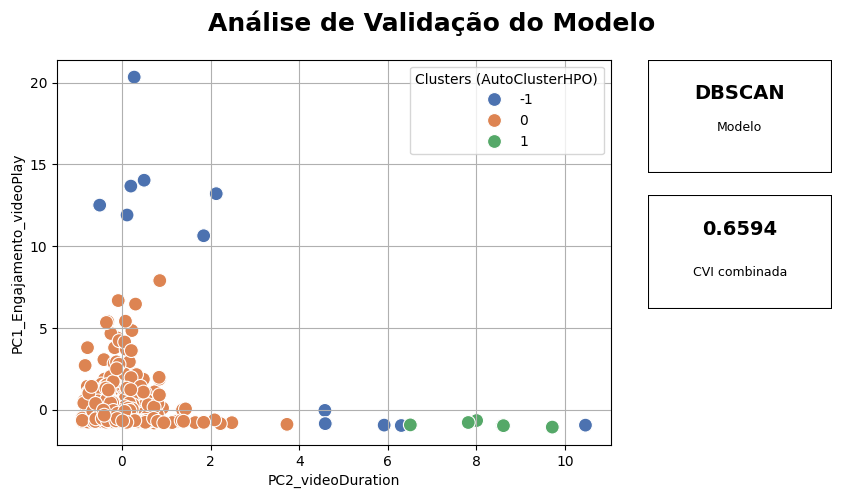

<Figure size 1000x700 with 0 Axes>

In [21]:
analiseValidacaoModeloPCA(df_reels[['PC2_videoDuration', 'PC1_Engajamento_videoPlay', 'Clusters (AutoClusterHPO)']], algo_names, scores)

In [22]:
df_reels['Clusters (AutoClusterHPO)'].value_counts()

Clusters (AutoClusterHPO)
 0    792
-1     12
 1      6
Name: count, dtype: int64

In [23]:
df_reels.columns

Index(['inputUrl', 'id', 'type', 'shortCode', 'caption', 'hashtags',
       'mentions', 'url', 'commentsCount', 'firstComment', 'latestComments',
       'dimensionsHeight', 'dimensionsWidth', 'displayUrl', 'images',
       'videoUrl', 'alt', 'likesCount', 'videoViewCount', 'videoPlayCount',
       'timestamp', 'childPosts', 'ownerFullName', 'ownerUsername', 'ownerId',
       'productType', 'videoDuration', 'isSponsored', 'musicInfo',
       'isCommentsDisabled', 'taggedUsers', 'coauthorProducers',
       'locationName', 'locationId', 'isPinned', 'data_hora', 'Width X Height',
       'Total de Engajamento', 'Tipo', 'PC1_Engajamento_videoPlay',
       'PC2_videoDuration', 'Clusters (AutoClusterHPO)', 'model', 'config',
       'score', 'algo_name'],
      dtype='object')

In [24]:
df_reels.groupby(['Clusters (AutoClusterHPO)'])[['commentsCount', 'likesCount', 'videoDuration', 'videoPlayCount']].describe().T

Clusters (AutoClusterHPO)         -1          0        1
commentsCount  count           12.00     792.00     6.00
               mean          4843.00     408.95   184.33
               std           4934.01     620.62   111.71
               min             58.00       0.00    75.00
               25%            104.50      90.00    92.00
               50%           4017.00     209.50   160.00
               75%           8662.00     464.25   266.25
               max          12664.00    7388.00   340.00
likesCount     count           12.00     792.00     6.00
               mean         89895.92    5543.27  1554.67
               std          84928.07    9535.63  1094.80
               min            571.00      -1.00   568.00
               25%           1374.75    1014.75   865.25
               50%         114192.00    2208.50  1162.50
               75%         139210.25    5681.25  1910.50
               max         246870.00   84386.00  3509.00
videoDuration  count           12.00     792.00     6.00
               mean           288.59      64.55   721.63
               std            283.53      34.92    84.00
               min             26.32       4.00   588.09
               25%             46.94      43.08   693.78
               50%            178.12      58.89   728.72
               75%            462.72      80.02   753.05
               max            900.03     368.57   840.94
videoPlayCount count           12.00     792.00     6.00
               mean       1123945.33  117883.27 29323.50
               std        1051533.29  157547.19 21024.91
               min          11443.00    1021.00 11177.00
               25%          52547.75   30337.50 20578.75
               50%        1197401.00   67658.00 23572.00
               75%        1848798.75  134811.25 26378.50
               max        2779910.00 1161903.00 70725.00

In [25]:
df_reels.columns

Index(['inputUrl', 'id', 'type', 'shortCode', 'caption', 'hashtags',
       'mentions', 'url', 'commentsCount', 'firstComment', 'latestComments',
       'dimensionsHeight', 'dimensionsWidth', 'displayUrl', 'images',
       'videoUrl', 'alt', 'likesCount', 'videoViewCount', 'videoPlayCount',
       'timestamp', 'childPosts', 'ownerFullName', 'ownerUsername', 'ownerId',
       'productType', 'videoDuration', 'isSponsored', 'musicInfo',
       'isCommentsDisabled', 'taggedUsers', 'coauthorProducers',
       'locationName', 'locationId', 'isPinned', 'data_hora', 'Width X Height',
       'Total de Engajamento', 'Tipo', 'PC1_Engajamento_videoPlay',
       'PC2_videoDuration', 'Clusters (AutoClusterHPO)', 'model', 'config',
       'score', 'algo_name'],
      dtype='object')

In [26]:
df = df_reels[df_reels['PC1_Engajamento_videoPlay'] > 10].describe()

df.groupby(['Clusters (AutoClusterHPO)'])[['commentsCount', 'likesCount', 'videoDuration', 'videoPlayCount']].describe().T

Clusters (AutoClusterHPO)      -1.00     0.00   7.00 
commentsCount  count            6.00      1.00   1.00
               mean          7976.89   3707.84   7.00
               std           3827.94       NaN    NaN
               min           1484.00   3707.84   7.00
               25%           7068.00   3707.84   7.00
               50%           8139.93   3707.84   7.00
               75%          10077.09   3707.84   7.00
               max          12664.00   3707.84   7.00
likesCount     count            6.00      1.00   1.00
               mean        154864.26  47432.22   7.00
               std          49729.13       NaN    NaN
               min         107283.00  47432.22   7.00
               25%         125884.38  47432.22   7.00
               50%         142178.79  47432.22   7.00
               75%         163211.27  47432.22   7.00
               max         246870.00  47432.22   7.00
videoDuration  count            6.00      1.00   1.00
               mean            83.44     66.96   7.00
               std             59.62       NaN    NaN
               min             26.32     66.96   7.00
               25%             39.50     66.96   7.00
               50%             66.18     66.96   7.00
               75%            115.05     66.96   7.00
               max            180.03     66.96   7.00
videoPlayCount count            6.00      1.00   1.00
               mean       1891727.70 611005.15   7.00
               std         586431.16       NaN    NaN
               min        1097923.00 611005.15   7.00
               25%        1582319.75 611005.15   7.00
               50%        1843122.86 611005.15   7.00
               75%        2178957.30 611005.15   7.00
               max        2779910.00 611005.15   7.00

## Analise de Sentimentos

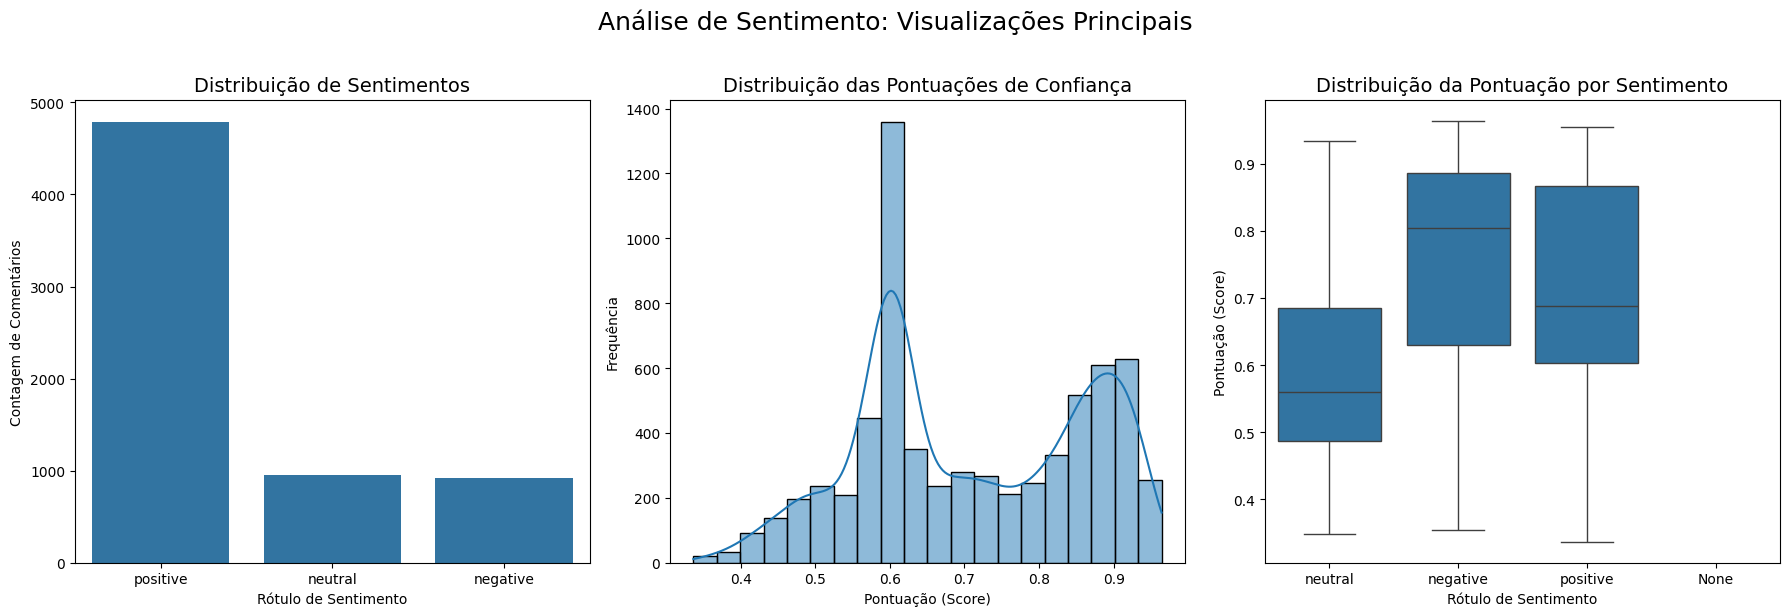

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define um título principal para a figura inteira.
fig.suptitle('Análise de Sentimento: Visualizações Principais', fontsize=18, y=1.02)

# --- 3. PLOTAGEM DOS GRÁFICOS ---

# Gráfico 1: Distribuição dos Rótulos (Gráfico de Barras)
sns.countplot(
    data=df_comments,
    x='sentiment_label',
    order=df_comments['sentiment_label'].value_counts().index,
    ax=axes[0]
)
axes[0].set_title('Distribuição de Sentimentos', fontsize=14)
axes[0].set_xlabel('Rótulo de Sentimento')
axes[0].set_ylabel('Contagem de Comentários')

# Gráfico 2: Distribuição da Pontuação (Histograma e Densidade)
sns.histplot(
    data=df_comments,
    x='sentiment_score',
    kde=True,
    ax=axes[1],
    bins=20
)
axes[1].set_title('Distribuição das Pontuações de Confiança', fontsize=14)
axes[1].set_xlabel('Pontuação (Score)')
axes[1].set_ylabel('Frequência')

# Crie a ordem dinamicamente a partir dos valores únicos
ordem_presente = df_comments['sentiment_label'].unique()

# Em seguida, passe essa lista para o parâmetro 'order'
sns.boxplot(
    data=df_comments,
    x='sentiment_label',
    y='sentiment_score',
    order=ordem_presente, # <-- Aqui está a mudança
    ax=axes[2]
)
axes[2].set_title('Distribuição da Pontuação por Sentimento', fontsize=14)
axes[2].set_xlabel('Rótulo de Sentimento')
axes[2].set_ylabel('Pontuação (Score)')

# --- 4. EXIBIÇÃO DA FIGURA ---
# Ajusta o layout para evitar sobreposição de títulos e rótulos.
plt.tight_layout()

plt.savefig('sentiment_plots.png')

# Exibe a figura completa.
plt.show()

## Modelagem de Topicos

In [28]:
topic_model.visualize_topics()

O gráfico "Intertopic Distance Map" (Mapa de Distância Intertópica) gerado pelo BERTopic, que utiliza a redução de dimensionalidade por UMAP, visualiza a distribuição e a relação entre os tópicos identificados em um conjunto de comentários do Instagram. Cada círculo representa um tópico, e o tamanho do círculo indica a frequência desse tópico no corpus de documentos: quanto maior o círculo, mais comentários estão associados a ele. A proximidade entre os círculos no mapa bidimensional (representado pelos eixos D1 e D2, que são componentes de uma projeção de alta dimensionalidade) sugere a similaridade semântica entre os tópicos. Tópicos que abordam temas parecidos (com palavras-chave e contextos de uso semelhantes) tendem a se agrupar, enquanto tópicos mais distintos e singulares se posicionam mais distantes. O destaque para um único círculo grande, isolado na parte inferior esquerda, indica que um tópico específico domina a maior parte do conjunto de dados, enquanto os demais tópicos são menores e mais dispersos, formando pequenos agrupamentos que representam temas menos prevalentes, mas semanticamente relacionados. Essa visualização é crucial para entender a estrutura temática do corpus e para identificar os tópicos mais relevantes e as relações entre eles.

In [29]:
topic_model.visualize_documents(docs_completos)

In [30]:
hierarchical_topics = topic_model.hierarchical_topics(docs_completos)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

 75%|███████▌  | 36/48 [37:07<12:16, 61.40s/it]

[GeminiDocsRefiner] Erro no tópico 0: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 200
Please retry in 41.661878618s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 200
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 41
}
]


 77%|███████▋  | 37/48 [38:07<11:11, 61.05s/it]

[GeminiDocsRefiner] Erro no tópico 0: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 200
Please retry in 41.395937645s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 200
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 41
}
]


 81%|████████▏ | 39/48 [40:09<09:08, 60.96s/it]

[GeminiDocsRefiner] Erro no tópico 0: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 200
Please retry in 39.398504023s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 200
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 39
}
]


 83%|████████▎ | 40/48 [41:09<08:05, 60.75s/it]

[GeminiDocsRefiner] Erro no tópico 0: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 200
Please retry in 39.143318796s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 200
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 39
}
]


 85%|████████▌ | 41/48 [42:09<07:04, 60.61s/it]

[GeminiDocsRefiner] Erro no tópico 0: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 200
Please retry in 38.873410319s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 200
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 38
}
]


 88%|████████▊ | 42/48 [43:10<06:03, 60.51s/it]

[GeminiDocsRefiner] Erro no tópico 0: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 200
Please retry in 38.600527571s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 200
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 38
}
]


 90%|████████▉ | 43/48 [44:10<05:02, 60.43s/it]

[GeminiDocsRefiner] Erro no tópico 0: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 200
Please retry in 38.339228762s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 200
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 38
}
]


 92%|█████████▏| 44/48 [45:10<04:01, 60.39s/it]

[GeminiDocsRefiner] Erro no tópico 0: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 200
Please retry in 38.05705373s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 200
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 38
}
]


 94%|█████████▍| 45/48 [46:11<03:01, 60.35s/it]

[GeminiDocsRefiner] Erro no tópico 0: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 200
Please retry in 37.781346609s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 200
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 37
}
]


 96%|█████████▌| 46/48 [47:11<02:00, 60.32s/it]

[GeminiDocsRefiner] Erro no tópico 0: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 200
Please retry in 37.52415523s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 200
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 37
}
]


 98%|█████████▊| 47/48 [48:11<01:00, 60.30s/it]

[GeminiDocsRefiner] Erro no tópico 0: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 200
Please retry in 37.266279429s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 200
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 37
}
]


100%|██████████| 48/48 [49:11<00:00, 61.50s/it]

[GeminiDocsRefiner] Erro no tópico 0: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 200
Please retry in 36.989488537s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 200
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 36
}
]


In [31]:
topic_model.visualize_heatmap()

In [32]:
# Corrected code
(df_comments.groupby(['Topic', 'Name'])
            .size()
            .reset_index(name='Count')
            .to_excel('topicos.xlsx', index=False))

KeyError: 'Topic'